# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels, visualize_phenotype_alignment
from lib.shared.align import apply_custom_offsets
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Name of the channel used for foci detection (e.g., "GH2AX", "DAPI"). The channel index will be automatically derived from this name.

In [3]:
# Parameters for testing
TEST_PLATE = 1
TEST_WELL = "A1"
TEST_TILE = 1123
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ['DAPI','TUBULIN','GH2AX','PHALLOIDIN']
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_yellow"]

# Parameters for feature extraction
FOCI_CHANNEL = "GH2AX"

In [4]:
# Load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# Apply illumination correction
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# # Create and display micropanel of corrected images
# print("Example corrected image:")
# corrected_microimages = [
#     Microimage(
#         corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
#     )
#     for i in range(corrected_image.shape[0])
# ]
# corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
# plt.show()

Loading test image...
Applying illumination correction...


## <font color='red'>SET PARAMETERS</font>

### Aligning (optional)

- `ALIGN`: Whether to conduct alignment. This is suggested **unless** each image is captured with each channel consecutively. 
- `TARGET`: Name of the channel that other channels will be aligned to.
- `SOURCE`: Name of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.
- `UPSAMPLE_FACTOR`: Subpixel alignment precision factor (default: 2). Higher values provide more precise alignment but increase processing time.
- `WINDOW`: Size of the region used for alignment calculation (default: 2). Higher values use a smaller centered region of the image.

### Custom Alignment (optional)

- `CUSTOM_CHANNEL_OFFSETS`: Dict mapping channel names to their (y, x) pixel offsets. Can be used independently or in combination with standard alignment for fine-tuning channel registration. Example: `{"DAPI": (5, 10), "AF750": (3, -2)}` shifts DAPI by 5 pixels up and 10 left, AF750 by 3 up and 2 right. Channel names must match those in `CHANNEL_NAMES`. Offset directions: +y = up, -y = down, +x = left, -x = right.

In [5]:
# Set alignment parameters
ALIGN = True

# Define alignment configurations for each plate
ALIGNMENTS = {
    1: {
        "target": 0,
        "source": 2,
        "riders": [3],
        "remove_channel": False,
        "window": 2,
        "upsample_factor": 4,
        "custom_channel_offsets": {2: (-5, 10), 3: (-5, 10)}
    },
    2: {
        "steps": [
            {
                "target": 0,
                "source": 2,
                "riders": [],
                "remove_channel": False
            },
            {
                "target": 2,
                "source": 3,
                "riders": [4],
                "remove_channel": "source"
            }
        ],
        "window": 2,
        "upsample_factor": 4,
        "custom_channel_offsets": {2: (-5, 12), 3: (-5, 12)}
    },
    3: {
        "target": 0,
        "source": 2,
        "riders": [3],
        "remove_channel": False,
        "window": 2,
        "upsample_factor": 4,
        "custom_channel_offsets": {2: (-12, 15), 3: (-12, 15)}
    },
    4: {
        "steps": [
            {
                "target": 0,
                "source": 2,
                "riders": [3],
                "remove_channel": False
            },
            {
                "target": 1,
                "source": 4,
                "riders": [],
                "remove_channel": "target"
            }
        ],
        "window": 2,
        "upsample_factor": 4,
        "custom_channel_offsets": {2: (0, 7), 3: (0, 7)}
    },
    5: {
        "target": 0,
        "source": 2,
        "riders": [3],
        "remove_channel": False,
        "window": 2,
        "upsample_factor": 4,
        "custom_channel_offsets": {2: (-5, 12), 3: (-5, 12)}
    },
    6: {
        "steps": [
            {
                "target": 0,
                "source": 2,
                "riders": [3],
                "remove_channel": False
            },
            {
                "target": 1,
                "source": 4,
                "riders": [],
                "remove_channel": "target"
            }
        ],
        "window": 2,
        "upsample_factor": 4,
        "custom_channel_offsets": {2: (0, 15), 3: (0, 15)}
    },
    7: {
        "steps": [
            {
                "target": 0,
                "source": 2,
                "riders": [3],
                "remove_channel": False
            },
            {
                "target": 1,
                "source": 4,
                "riders": [],
                "remove_channel": "target"
            }
        ],
        "window": 2,
        "upsample_factor": 4,
        "custom_channel_offsets": {2: (-5, 12), 3: (-5, 12)}
    },
    8: {
        "steps": [
            {
                "target": 0,
                "source": 2,
                "riders": [3],
                "remove_channel": False
            },
            {
                "target": 1,
                "source": 4,
                "riders": [],
                "remove_channel": "target"
            }
        ],
        "window": 2,
        "upsample_factor": 4,
        "custom_channel_offsets": {2: (-12, 12), 3: (-12, 12)}
    }
}

In [6]:
# Start with the corrected image
aligned_image = corrected_image.copy()

# Get plate-specific configuration
plate_config = ALIGNMENTS.get(TEST_PLATE, {})
plate_window = plate_config.get("window", 2)
plate_upsample = plate_config.get("upsample_factor", 2)
plate_custom_offsets = plate_config.get("custom_channel_offsets", None)

# Apply custom offsets 
if plate_custom_offsets:
    print(f"Custom offsets: {plate_custom_offsets}")
    aligned_image = apply_custom_offsets(aligned_image, plate_custom_offsets)

# Apply automatic alignment
if ALIGN:
    if "steps" in plate_config:
        # Multi-step alignment
        for step_num, step in enumerate(plate_config["steps"], 1):
            print(f"  Step {step_num}: target={step['target']}, source={step['source']}, riders={step['riders']}")
            aligned_image = align_phenotype_channels(
                aligned_image,
                target=step["target"],
                source=step["source"],
                riders=step["riders"],
                remove_channel=step["remove_channel"],
                upsample_factor=plate_upsample,
                window=plate_window,
                verbose=True,
            )
    elif "target" in plate_config and "source" in plate_config:
        # Single-step alignment
        print(f"  target={plate_config['target']}, source={plate_config['source']}, riders={plate_config.get('riders', [])}")
        aligned_image = align_phenotype_channels(
            aligned_image,
            target=plate_config["target"],
            source=plate_config["source"],
            riders=plate_config.get("riders", []),
            remove_channel=plate_config.get("remove_channel", False),
            upsample_factor=plate_upsample,
            window=plate_window,
            verbose=True,
        )

Custom offsets: {2: (-5, 10), 3: (-5, 10)}
  target=0, source=2, riders=[3]

=== Phenotype Channel Alignment Offsets ===
  Target channel (index 0): no shift (reference)
  Source channel (index 2): shift = [  5. -10.] pixels (y, x)
  Rider channel (index 3): shift = [  5. -10.] pixels (y, x)


### Visualize Alignment Quality (Optional)

Visualize channel alignment across 16 locations in the image. The first channel (DAPI) is shown in grayscale with the remaining 3 channels as an RGB overlay. You may want to consider removing channels for a first pass if you want to visualize alignment between different rounds.

- `VIZ_CHANNELS`: List of exactly 4 channel names to visualize (1st=grayscale base, 2nd-4th=RGB overlay)

Visualizing alignment across 16 locations...


/lab/ops_analysis/cheeseman/aconcagua-analysis-new/brieflow/workflow/lib/phenotype/align_channels.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


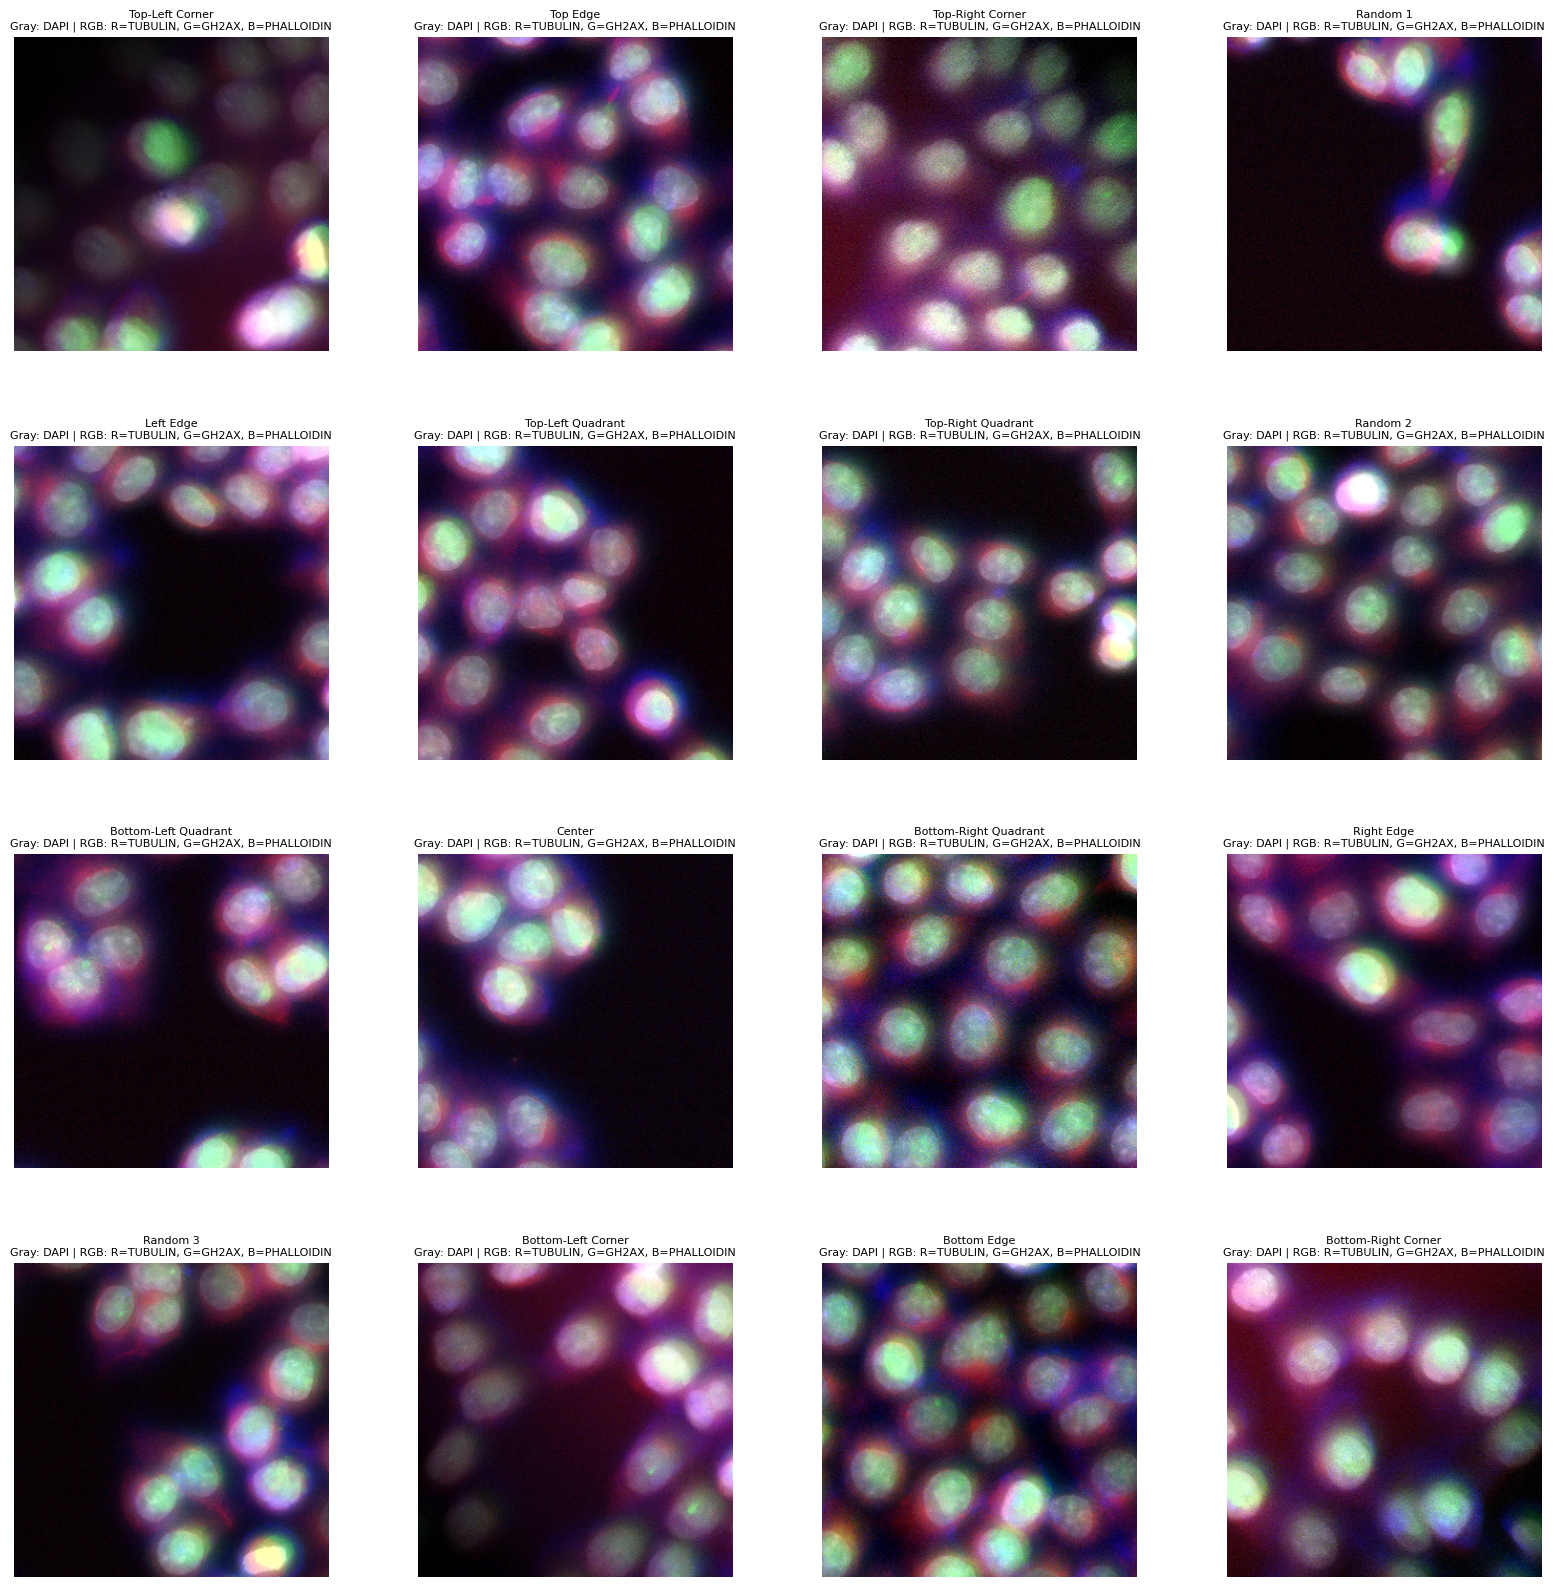

In [7]:
# Configure which channels to visualize for alignment verification
VIZ_CHANNELS = [
    "DAPI",       # Grayscale base layer
    "TUBULIN",    # Red channel in RGB overlay
    "GH2AX",      # Green channel in RGB overlay
    "PHALLOIDIN", # Blue channel in RGB overlay
]

if VIZ_CHANNELS is not None:
    print("Visualizing alignment across 16 locations...")
    fig = visualize_phenotype_alignment(
        aligned_image,
        channel_names=CHANNEL_NAMES,
        viz_channels=VIZ_CHANNELS,
        crop_size=300
    )
    plt.show()
else:
    print("Skipping visualization (VIZ_CHANNELS not set)")

## <font color='red'>SET PARAMETERS</font>

### Segmentation

**IMPORTANT: GPU Recommendation for CPSAM**
If testing the CPSAM model (`cyto_model="cpsam"`), we strongly recommend:
- Using a GPU-enabled machine (`GPU=True`)
- Allocating sufficient time (segmentation can take 30+ minutes per tile)
- Consider running this notebook in a GPU-enabled environment or testing on a smaller region

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use. Options: "cyto3" (default), "cyto2", "cyto", or "cpsam" (requires Cellpose 4.x).
- `CELL_FLOW_THRESHOLD` & `NUCLEI_FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELL_CELLPROB_THRESHOLD` & `NUCLEI_CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- `HELPER_INDEX`: (Optional) Index of additional channel to help with CPSAM segmentation. Only used with `cyto_model="cpsam"`. Default is None.
- Note: For Cellpose 3.x models (cyto3, cyto2), nuclei and cell diameters will be estimated automatically. For CPSAM (Cellpose 4.x), diameters can be left as None and will be estimated from initial segmentation results.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `CELL_PROB_THRESHOLD` & `NUCLEI_PROB_THRESHOLD`: Probability threshold for segmentation. Default is 0.479071.
- `CELL_NMS_THRESHOLD` & `NUCLEI_NMS_THRESHOLD`: Non-maximum suppression threshold. Default is 0.3.

#### Watershed Parameters (if using "watershed")
- `THRESHOLD_DAPI`: Threshold for nuclei segmentation. 
- `THRESHOLD_CELL`: Threshold for cell boundary segmentation.
- `NUCLEUS_AREA`: Range for filtering nuclei by area as a tuple (min, max).

In [ ]:
# Common parameters
CYTO_CHANNEL = "PHALLOIDIN"
GPU = False
RECONCILE = "contained_in_cells"
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    NUCLEI_FLOW_THRESHOLD = 0.4
    NUCLEI_CELLPROB_THRESHOLD = 0.0
    CELL_FLOW_THRESHOLD = 1
    CELL_CELLPROB_THRESHOLD = 0
    HELPER_INDEX = None  # Optional: channel index to help with CPSAM segmentation

    # Only estimate diameters for non-CPSAM models
    if CELLPOSE_MODEL != "cpsam":
        from lib.shared.segment_cellpose import estimate_diameters
        print("Estimating optimal cell and nuclei diameters...")
        NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
            aligned_image,
            dapi_index=DAPI_INDEX,
            cyto_index=CYTO_INDEX,
            cyto_model=CELLPOSE_MODEL,
        )
    else:
        print("CPSAM model selected. Initial diameters set to None.")
        print("Note: Diameters will be estimated automatically from segmentation results in the next cell.")
        NUCLEI_DIAMETER = None  # Will be estimated from segmentation
        CELL_DIAMETER = None    # Will be estimated from segmentation

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    NUCLEI_PROB_THRESHOLD = 0.479071
    NUCLEI_NMS_THRESHOLD = 0.3
    CELL_PROB_THRESHOLD = 0.479071
    CELL_NMS_THRESHOLD = 0.3

/lab/barcheese01/mdiberna/miniconda3/envs/brieflow_aconcagua_new/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Estimating optimal cell and nuclei diameters...


/lab/barcheese01/mdiberna/miniconda3/envs/brieflow_aconcagua_new/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


Estimating nuclei diameters...
Estimated nuclear diameter: 42.7 pixels
Estimating cell diameters...
Estimated cell diameter: 68.1 pixels


Segmenting image with cellpose...


found 1309 nuclei before removing edges
found 1288 cells before removing edges


removing edges


found 1252 nuclei before reconciling
found 1219 cells before reconciling


reconciling masks with method how=contained_in_cells

Nuclei per cell statistics:
--------------------------
Cells with 0 nuclei: 17
Cells with 1 nuclei: 1190
Cells with 2 nuclei: 11
Cells with 3 nuclei: 1
--------------------------



found 1202 nuclei/cells after reconciling


Number of nuclei segmented: 1202
Number of cells segmented: 1202
Example microplots for DAPI channel and nuclei segmentation:


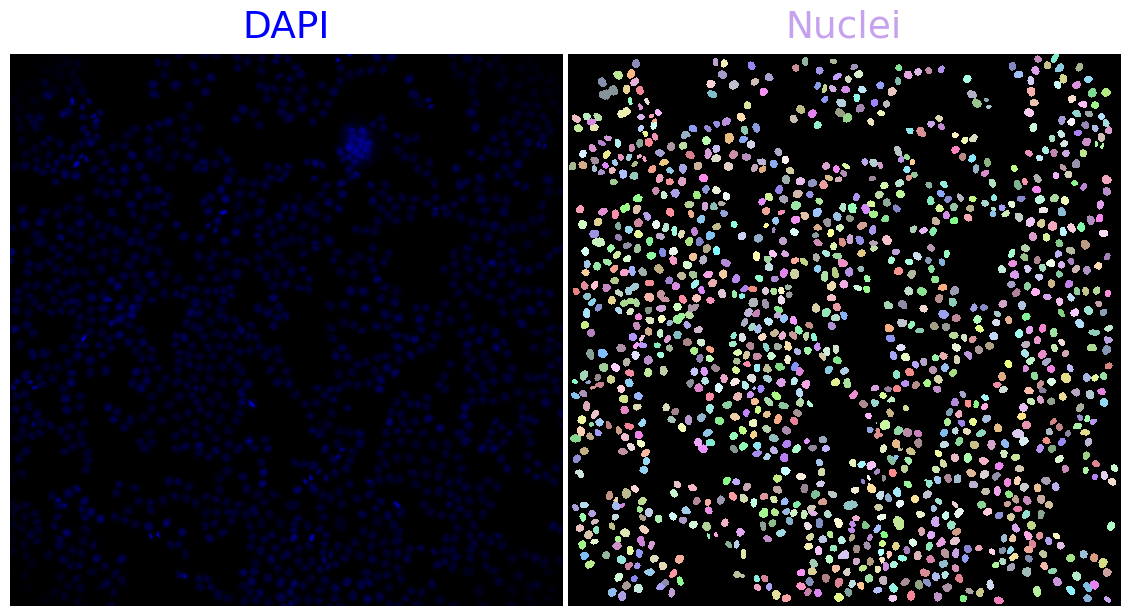

Example microplots for merged channels and cells segmentation:


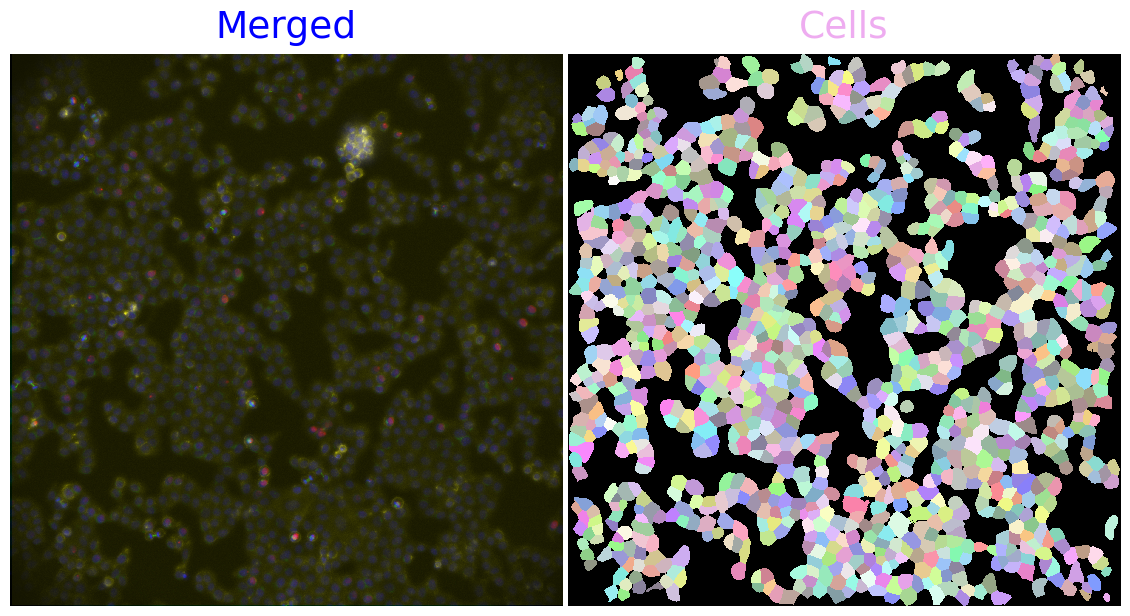

Example microplot for phenotype data annotated with segmentation:


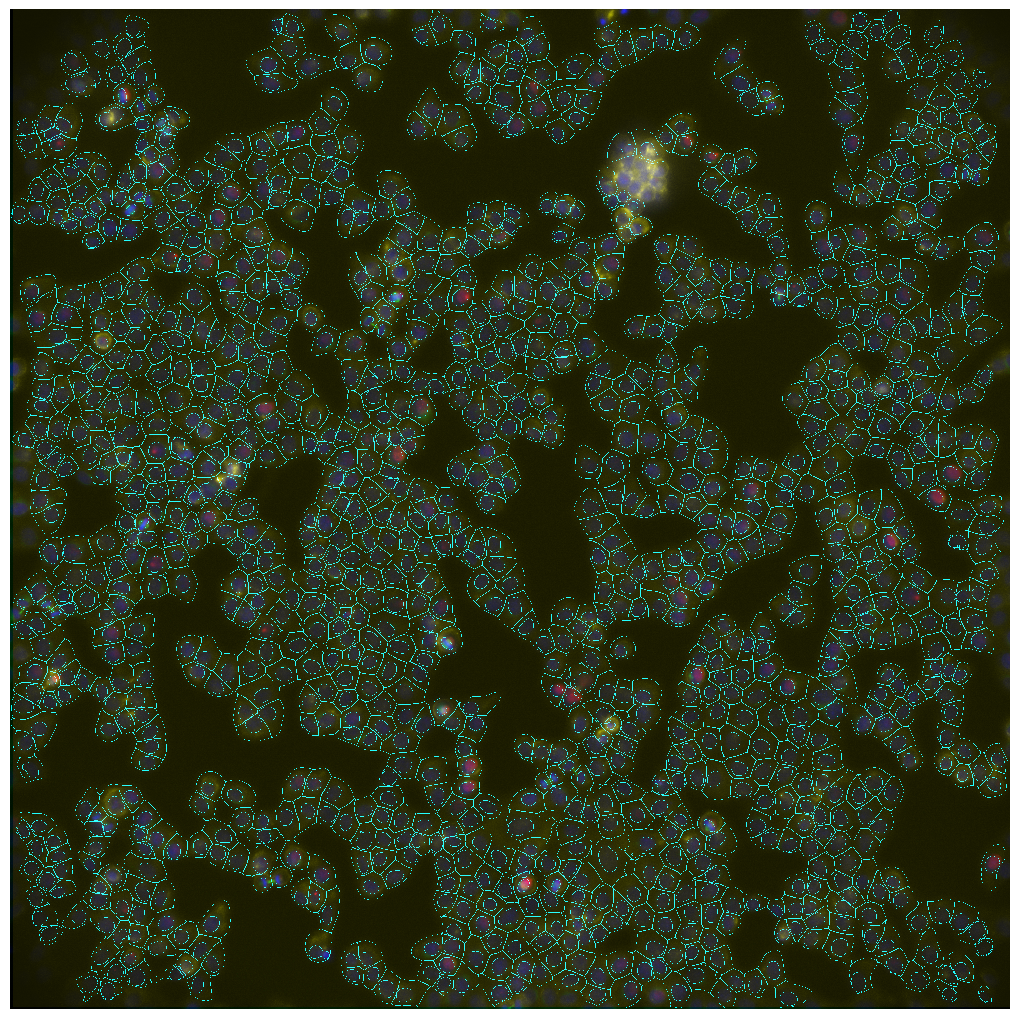

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 1202


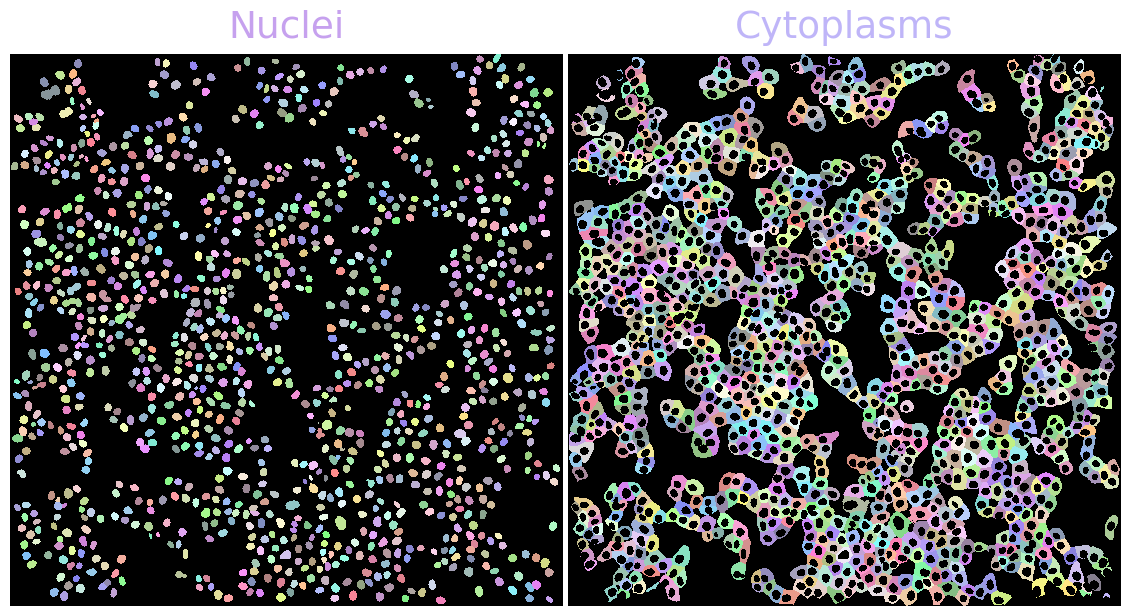

In [ ]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    from lib.shared.segment_cellpose import segment_cellpose
    nuclei, cells = segment_cellpose(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
            nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
            cell_flow_threshold=CELL_FLOW_THRESHOLD,
            cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        helper_index=HELPER_INDEX,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "microsam":
    from lib.shared.segment_microsam import segment_microsam
    nuclei, cells = segment_microsam(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "stardist":
    from lib.shared.segment_stardist import segment_stardist
    nuclei, cells = segment_stardist(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            nuclei_prob_threshold=NUCLEI_PROB_THRESHOLD,
            nuclei_nms_threshold=NUCLEI_NMS_THRESHOLD,
            cell_prob_threshold=CELL_PROB_THRESHOLD,
            cell_nms_threshold=CELL_NMS_THRESHOLD,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        aligned_image,
        channel_names="Merged",
        cmaps=CHANNEL_CMAPS,
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(aligned_image, nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=CHANNEL_CMAPS + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

if SEGMENTATION_METHOD == "cellpose" and CELLPOSE_MODEL == "cpsam":
    from skimage.measure import regionprops
    import numpy as np

    # Calculate nuclei diameters
    nuclei_props = regionprops(nuclei)
    nuclei_diameters = [prop.equivalent_diameter for prop in nuclei_props]
    estimated_nuclei_diameter = np.mean(nuclei_diameters)
    print(f"Nuclei - Average diameter: {estimated_nuclei_diameter:.2f} pixels")

    # Calculate cell diameters  
    cells_props = regionprops(cells)
    cells_diameters = [prop.equivalent_diameter for prop in cells_props]
    estimated_cell_diameter = np.mean(cells_diameters)
    print(f"Cells - Average diameter: {estimated_cell_diameter:.2f} pixels")
    
    # Update the diameter variables for config
    NUCLEI_DIAMETER = estimated_nuclei_diameter
    CELL_DIAMETER = estimated_cell_diameter
    print(f"\nUpdated NUCLEI_DIAMETER to {NUCLEI_DIAMETER:.2f} pixels")
    print(f"Updated CELL_DIAMETER to {CELL_DIAMETER:.2f} pixels")

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed. You manually can set `NUCLEI_DIAMETER` and `CELL_DIAMETER` and rerun the above blocks as many times as needed.

## <font color='red'>SET PARAMETERS</font>

### Feature extraction

- `CP_METHOD`: Methodology for phenotype feature extraction.  
    - `cp_multichannel`: Use emulated code from original _Feldman et. al. 2019_ to extract CellProfiler-like features.
    - `cp_measure`: Use Pythonic version of [CellProfiler](https://github.com/afermg/cp_measure) directly from Imaging Platform. Still in development, may run slowly in Jupyter notebook for testing purposes.

  #### BEFORE USING CP MEASURE
Ensure your current conda environment is set up for cp_measure when using this method. This can be done in the following manner:
1. Clone brieflow environment:

   `conda create --name brieflow_cpmeasure_env --clone brieflow_main_env`

2. Activate the environment:

    `conda activate brieflow_cpmeasure_env`

3. Install the required package:

    `pip install cp-measure`

4. Verify dependencies with `conda list` - cp_measure requires Python 3.8 or later, and the following package versions:

    - NumPy 1.24.3*
    - centrosome 1.3.0*
    
   If you have issues running cp_measure, you may need to downgrade these packages in the cloned environment.

In [10]:
CP_METHOD = "cp_multichannel"

In [11]:
print("Extracting phenotype features:")

# Compute foci channel index from channel name
FOCI_CHANNEL_INDEX = CHANNEL_NAMES.index(FOCI_CHANNEL)

if CP_METHOD == "cp_measure":
    from lib.phenotype.extract_phenotype_cp_measure import extract_phenotype_cp_measure
    # Extract features using cp_measure
    phenotype_cp = extract_phenotype_cp_measure(
        aligned_image,
        nuclei=nuclei,
        cells=cells,
        cytoplasms=cytoplasms,
        channel_names=CHANNEL_NAMES,
    )
else:
    from lib.phenotype.extract_phenotype_cp_multichannel import (
        extract_phenotype_cp_multichannel,
    )
    # Extract features using CellProfiler emulator
    phenotype_cp = extract_phenotype_cp_multichannel(
        aligned_image,
        nuclei=nuclei,
        cells=cells,
        wildcards=WILDCARDS,
        cytoplasms=cytoplasms,
        foci_channel=FOCI_CHANNEL_INDEX,
        channel_names=CHANNEL_NAMES,
    )

phenotype_cp

Extracting phenotype features:


label well  tile    nucleus_i    nucleus_j  nucleus_bounds_0  \
0         1   A1  1123    45.188060  1268.841045                21   
1         2   A1  1123    44.540749  1420.522026                30   
2         3   A1  1123    26.890921  2605.147616                 2   
3         4   A1  1123    32.509640  2514.858340                13   
4         5   A1  1123    54.897816   834.809672                33   
...     ...  ...   ...          ...          ...               ...   
1197   1198   A1  1123  2919.050544  2115.999222              2900   
1198   1199   A1  1123  2918.238451  2780.684783              2897   
1199   1200   A1  1123  2929.350407  2304.978463              2909   
1200   1201   A1  1123  2917.953638  1738.052068              2900   
1201   1202   A1  1123  2925.094828  2887.044181              2908   

      nucleus_bounds_1  nucleus_bounds_2  nucleus_bounds_3       cell_i  ...  \
0                 1250                69              1287    54.538462  ...   
1                 1401                60              1440    45.411909  ...   
2                 2584                54              2628    32.894522  ...   
3                 2496                52              2536    38.301923  ...   
4                  818                78               854    52.177778  ...   
...                ...               ...               ...          ...  ...   
1197              2095              2940              2138  2916.571360  ...   
1198              2759              2940              2805  2901.787224  ...   
1199              2279              2951              2332  2917.399158  ...   
1200              1715              2937              1763  2916.774637  ...   
1201              2868              2943              2907  2914.079632  ...   

      cytoplasm_zernike_9_1  cytoplasm_zernike_9_3  cytoplasm_zernike_9_5  \
0                  0.005180               0.091713               0.050965   
1                  0.108897               0.014070               0.137399   
2                  0.169455               0.047399               0.109414   
3                  0.076916               0.122376               0.012216   
4                  0.143393               0.047697               0.028874   
...                     ...                    ...                    ...   
1197               0.071951               0.045027               0.033713   
1198               0.102529               0.151786               0.065430   
1199               0.029603               0.030622               0.036535   
1200               0.131225               0.014139               0.050488   
1201               0.087829               0.038917               0.036862   

      cytoplasm_zernike_9_7  cytoplasm_zernike_9_9  \
0                  0.033467               0.057942   
1                  0.064004               0.061450   
2                  0.108982               0.053571   
3                  0.045510               0.034268   
4                  0.037940               0.024969   
...                     ...                    ...   
1197               0.032861               0.006475   
1198               0.087826               0.076206   
1199               0.015290               0.041778   
1200               0.024481               0.047157   
1201               0.059502               0.003226   

      cytoplasm_number_neighbors_1  cytoplasm_percent_touching_1  \
0                                2                      0.255682   
1                                0                      0.000000   
2                                2                      0.355491   
3                                2                      0.261194   
4                                2                      0.253304   
...                            ...                           ...   
1197                             2                      0.330000   
1198                             1                      0.300000   
1199              

In [12]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_foci_area',
 'cell_foci_count',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',

## Add phenotype process parameters to config file

In [13]:
# Add phenotype section
config["phenotype"] = {
    "foci_channel_index": FOCI_CHANNEL_INDEX,
    "channel_names": CHANNEL_NAMES,
    "align": ALIGN,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "segmentation_method": SEGMENTATION_METHOD,
    "reconcile": RECONCILE,
    "gpu": GPU,
    "cp_method": CP_METHOD,
}

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["phenotype"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "nuclei_flow_threshold": NUCLEI_FLOW_THRESHOLD,
        "nuclei_cellprob_threshold": NUCLEI_CELLPROB_THRESHOLD,
        "cell_flow_threshold": CELL_FLOW_THRESHOLD,
        "cell_cellprob_threshold": CELL_CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
    })
    # Add helper_index only if it's defined
    if HELPER_INDEX is not None:
        config["phenotype"]["helper_index"] = HELPER_INDEX
elif SEGMENTATION_METHOD == "microsam":
    config["phenotype"].update({
        "microsam_model": MICROSAM_MODEL,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["phenotype"].update({
        "stardist_model": STARDIST_MODEL,
        "nuclei_prob_threshold": NUCLEI_PROB_THRESHOLD,
        "nuclei_nms_threshold": NUCLEI_NMS_THRESHOLD,
        "cell_prob_threshold": CELL_PROB_THRESHOLD,
        "cell_nms_threshold": CELL_NMS_THRESHOLD,
    })

# Add alignment configurations if defined
if ALIGN:  
    config["phenotype"]["alignments"] = ALIGNMENTS

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)